# Setup inicial

In [1]:
import lightgbm as lgb

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

pd.options.display.float_format = '{:20,.2f}'.format 

In [3]:
#Cargamos df
path = 'https://drive.google.com/uc?export=download&id=1PZBhJtUEIwUPHXZ2xEuyk2Yhp4AUgXCy'
path2 = 'https://drive.google.com/uc?export=download&id=1pEe4cy4LxAnb_ySOxNrETOqfwusgg9Wy'

df = pd.read_csv(path)
df_test = pd.read_csv(path2)

# Analisis exploratorio

In [4]:
df.head()

,Customer,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,1,33,Private Sector/Self Employed,Yes,550000,6,0,No,No,1
1,2,28,Private Sector/Self Employed,Yes,800000,7,0,Yes,No,0
2,3,31,Private Sector/Self Employed,Yes,1250000,4,0,No,No,0
3,4,31,Government Sector,No,300000,7,0,No,No,0
4,5,28,Private Sector/Self Employed,Yes,1250000,3,0,No,No,0


In [5]:
del df['Customer']  
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  1490 non-null   int64 
 1   Employment Type      1490 non-null   object
 2   GraduateOrNot        1490 non-null   object
 3   AnnualIncome         1490 non-null   int64 
 4   FamilyMembers        1490 non-null   int64 
 5   ChronicDiseases      1490 non-null   int64 
 6   FrequentFlyer        1490 non-null   object
 7   EverTravelledAbroad  1490 non-null   object
 8   TravelInsurance      1490 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 104.9+ KB


Descartamos la variable de "customer" dado que no agrega valor para el modelo.

También vemos que todas las variables están completas y no se presentan datos faltantes. Hay datos numéricos y categóricos.

La variable objetivo es desbalanceada (hay más casos negativos que positivos), lo que va a influir sobre como evaluamos los modelos de clasificación.

In [6]:
df.TravelInsurance.value_counts()

0    958
1    532
Name: TravelInsurance, dtype: int64

A continuación vamos a visualizar como se distribuyen los datos en las distintas variables.

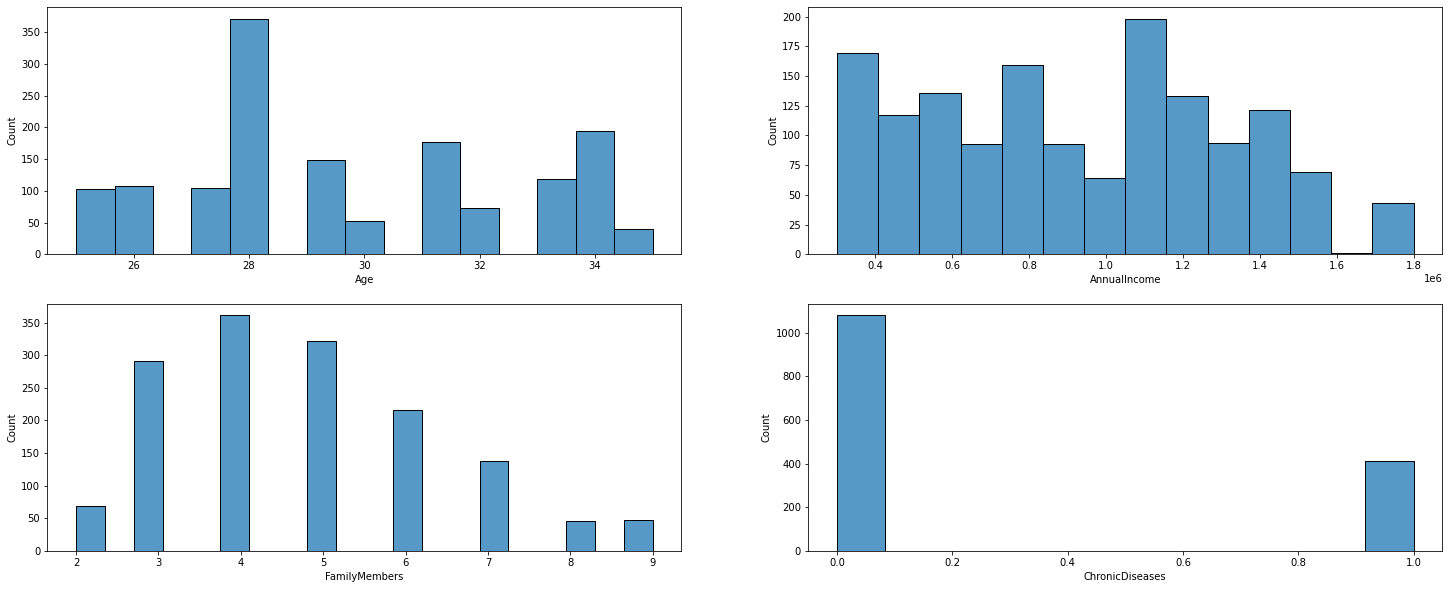

In [7]:
#Distribucion en variables numericas
temp = df.drop('TravelInsurance', axis=1).select_dtypes('int64')

fig, axes = plt.subplots(2,2, figsize=(25,10))
axes = np.ravel(axes)

for h,i in enumerate(temp.columns):
    sns.histplot(data=temp[i], ax=axes[h])

<AxesSubplot:>

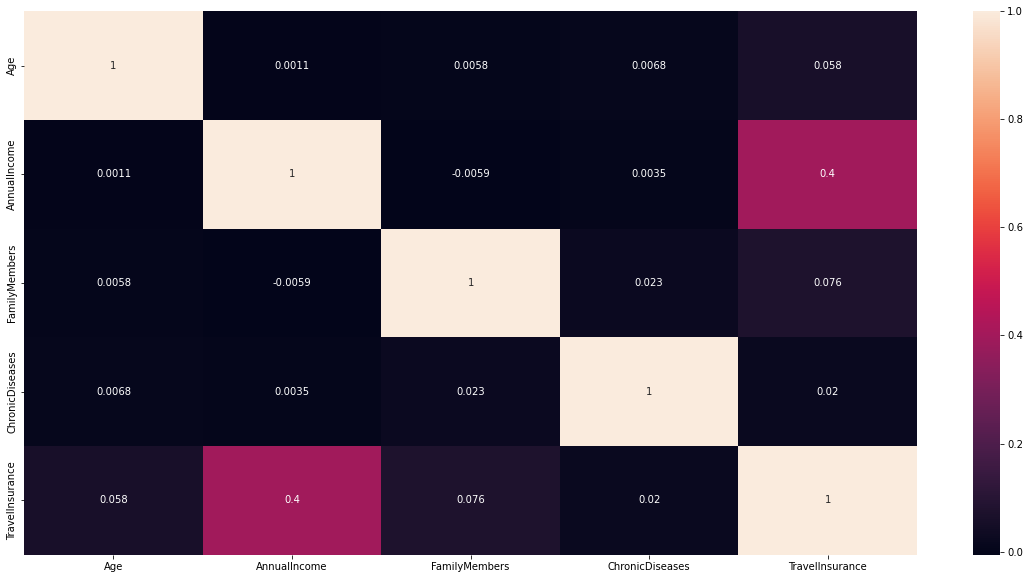

In [8]:
#Correlacion entre variables numericas y variable objetivo
plt.figure(figsize=(20, 10))
sns.heatmap(df.select_dtypes('int64').corr(method='spearman'), annot = True)

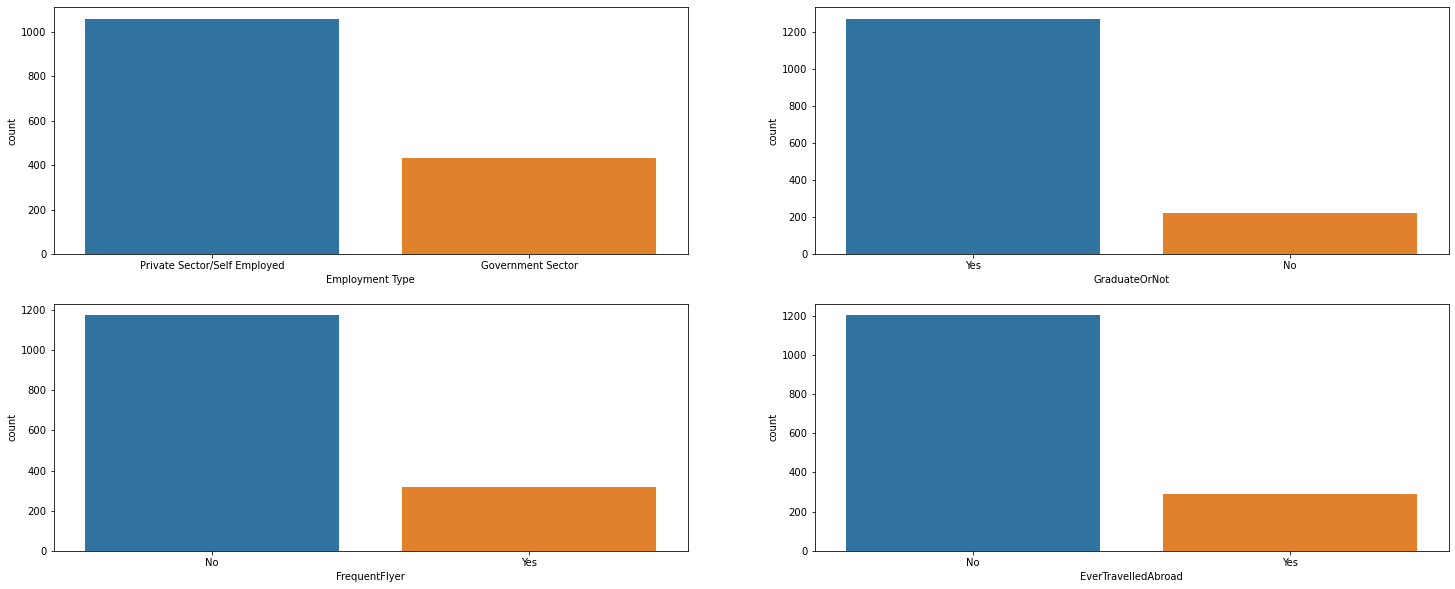

In [9]:
#Distribucion en variables categoricas
temp = df.select_dtypes('object')

fig, axes = plt.subplots(2,2, figsize=(25,10))
axes = np.ravel(axes)

for h,i in enumerate(temp.columns):
    sns.countplot(data=temp, x=i, ax=axes[h])

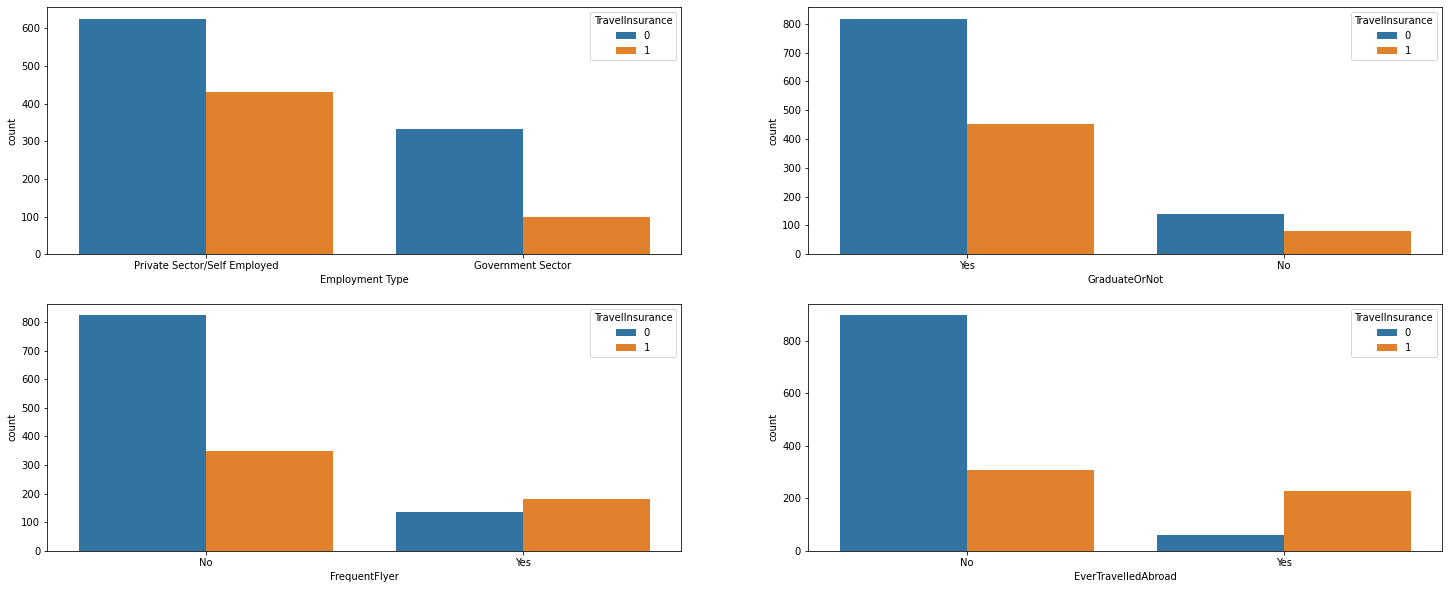

In [10]:
#Correlacion entre variables categoricas y variable objetivo
temp = df.select_dtypes('object').columns

fig, axes = plt.subplots(2,2, figsize=(25,10))
axes = np.ravel(axes)

for h,i in enumerate(temp):
    sns.countplot(data=df, x=i, hue='TravelInsurance', ax=axes[h])

# Preprocesamiento

## Encoding


In [11]:
#Convertimos las variables categóricas a numéricas
df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

In [12]:
df.head()

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance,Employment Type_Government Sector,Employment Type_Private Sector/Self Employed,GraduateOrNot_No,GraduateOrNot_Yes,FrequentFlyer_No,FrequentFlyer_Yes,EverTravelledAbroad_No,EverTravelledAbroad_Yes
0,33,550000,6,0,1,0,1,0,1,1,0,1,0
1,28,800000,7,0,0,0,1,0,1,0,1,1,0
2,31,1250000,4,0,0,0,1,0,1,1,0,1,0
3,31,300000,7,0,0,1,0,1,0,1,0,1,0
4,28,1250000,3,0,0,0,1,0,1,1,0,1,0


In [13]:
df_test.head()

,Customer,Age,AnnualIncome,FamilyMembers,ChronicDiseases,Employment Type_Government Sector,Employment Type_Private Sector/Self Employed,GraduateOrNot_No,GraduateOrNot_Yes,FrequentFlyer_No,FrequentFlyer_Yes,EverTravelledAbroad_No,EverTravelledAbroad_Yes
0,1491,29,1100000,4,0,0,1,0,1,1,0,1,0
1,1492,28,750000,5,1,0,1,0,1,0,1,1,0
2,1493,31,1500000,4,0,1,0,0,1,0,1,0,1
3,1494,28,1400000,3,0,0,1,0,1,1,0,0,1
4,1495,33,1500000,4,0,0,1,0,1,0,1,0,1


<AxesSubplot:>

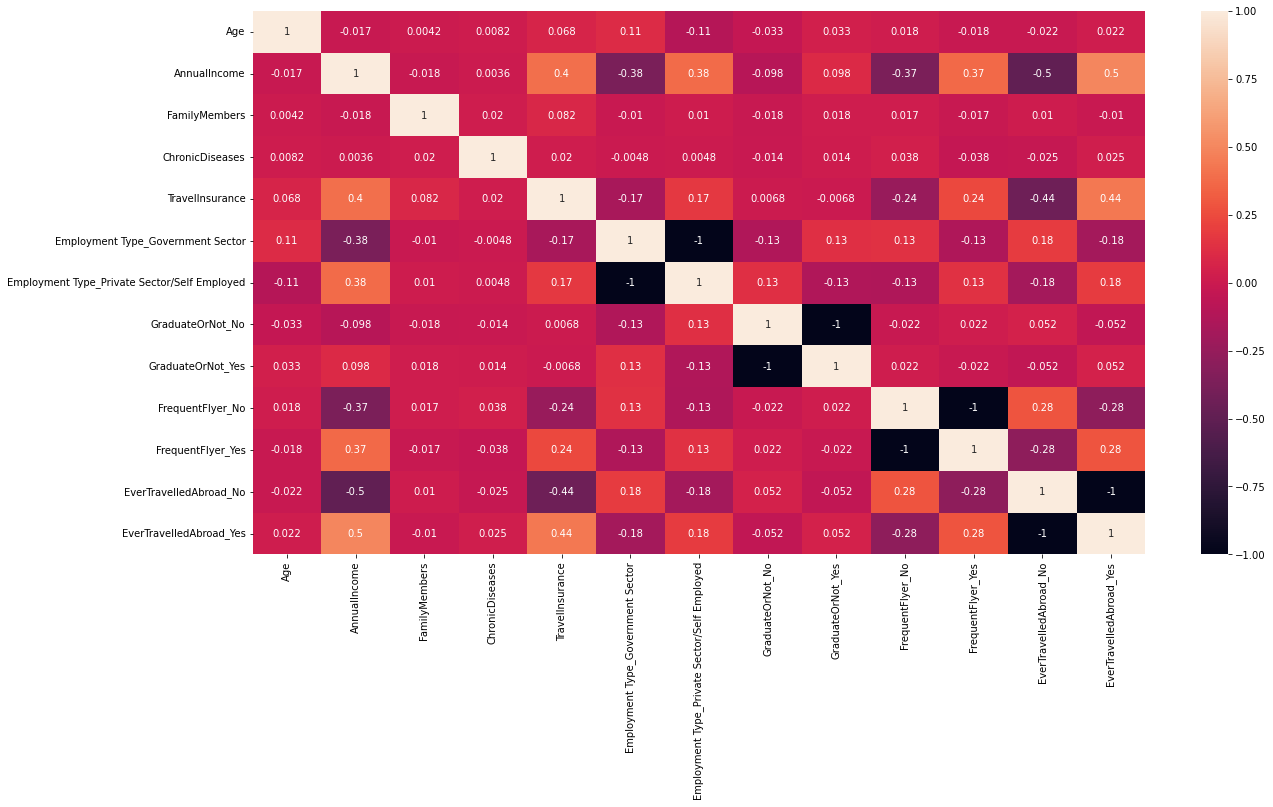

In [14]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(method='pearson'), annot = True) #Realizamos un heatmap de correlación buscando algún feature numérico que presente correlación mayor a 0.7 para poder descartarlo pero no se presenta.

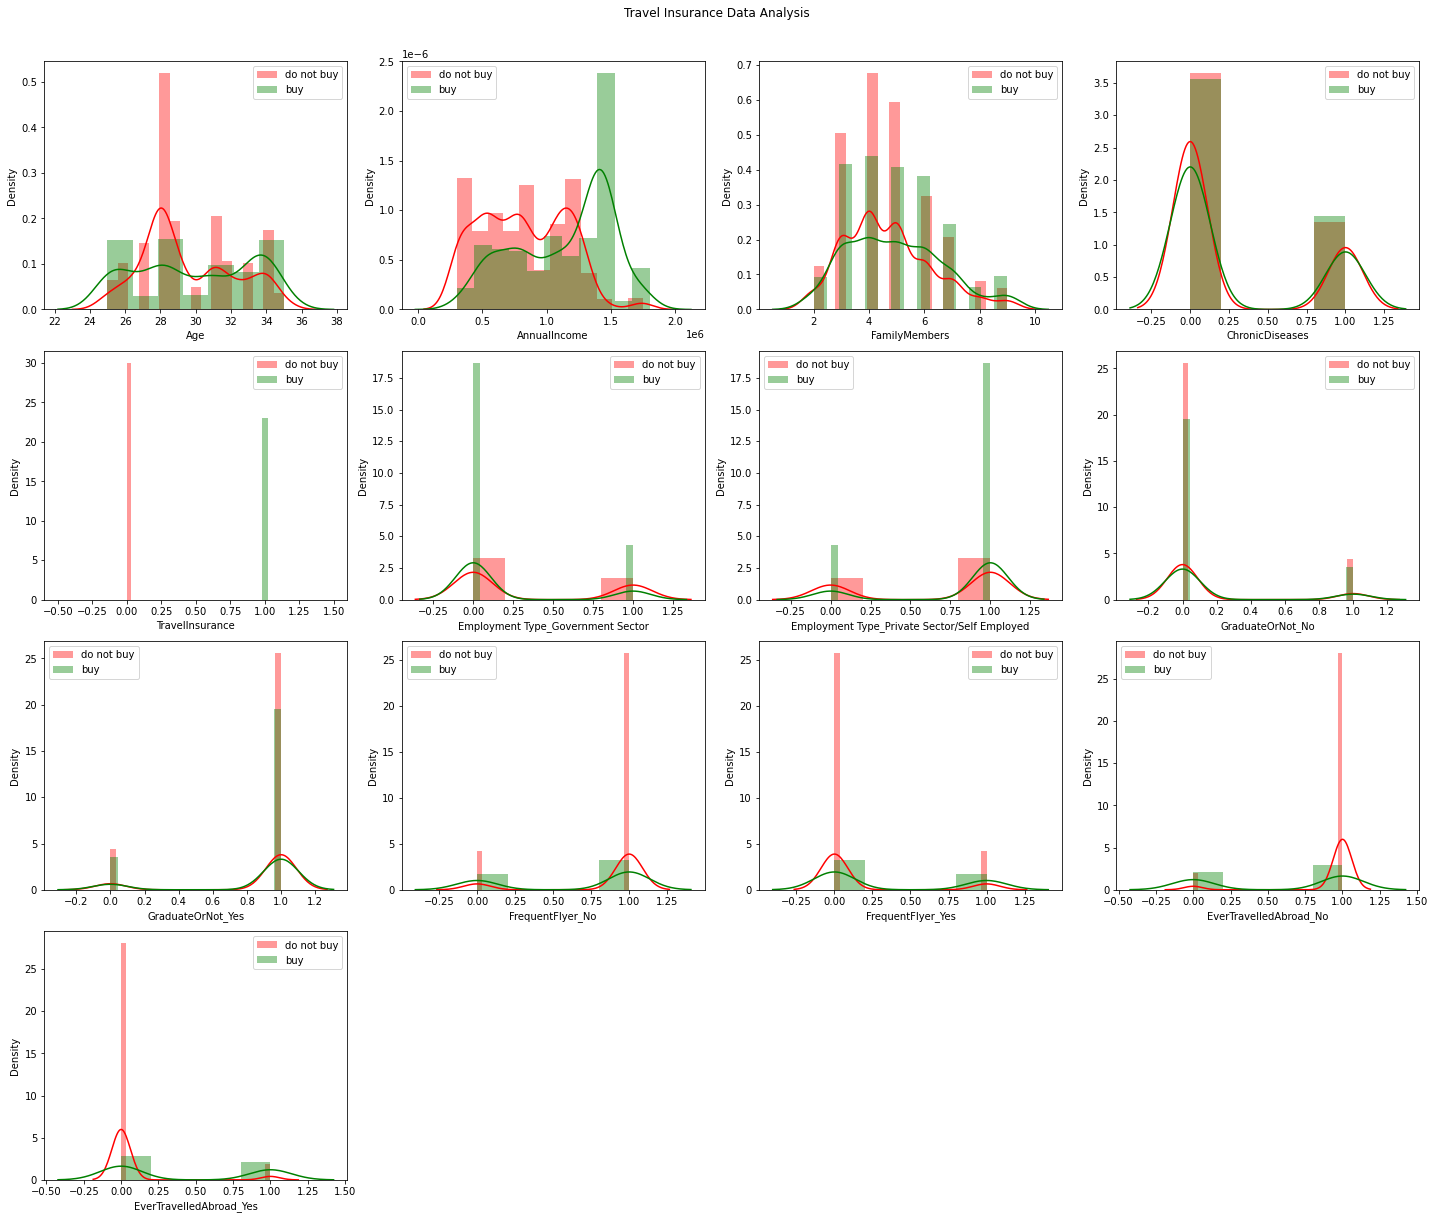

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

fig = plt.figure(figsize = (20, 25))
j = 0

for i in df.columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(df[i][df.TravelInsurance==0], color='r', label = 'do not buy') 
    sns.distplot(df[i][df.TravelInsurance==1], color='g', label = 'buy')
    plt.legend(loc='best')
fig.suptitle('Travel Insurance Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

## Scaling

In [16]:
#train
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = df.columns 

#test
scaler_test = MinMaxScaler()
df_test_scaled = scaler_test.fit_transform(df_test)

df_test_scaled = pd.DataFrame(df_test_scaled)
df_test_scaled.columns = df_test.columns

In [17]:
df_scaled.head()

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance,Employment Type_Government Sector,Employment Type_Private Sector/Self Employed,GraduateOrNot_No,GraduateOrNot_Yes,FrequentFlyer_No,FrequentFlyer_Yes,EverTravelledAbroad_No,EverTravelledAbroad_Yes
0,0.80,0.17,0.57,0.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00
1,0.30,0.33,0.71,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00
2,0.60,0.63,0.29,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00
3,0.60,0.00,0.71,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00
4,0.30,0.63,0.14,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00


## Split

Debido a que todas las columnas categóricas tienen son binarias, vamos a mantener solo una de las columnas de cada una, porque tienen correlación perfecta.

In [18]:
# División entre instancias y etiquetas
X, y = df_scaled.drop(columns=['TravelInsurance', "GraduateOrNot_No", "Employment Type_Private Sector/Self Employed","FrequentFlyer_No","EverTravelledAbroad_No" ]), df_scaled.TravelInsurance

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Modelos

## Lightgbm

In [19]:
params = {'max_depth':range(3,12), 'min_data_in_leaf':[1,2,3,4], 'learning_rate':[.001, .005, .01, .05, .1, .3]} 
grid_search_cv = GridSearchCV(lgb.LGBMClassifier(random_state=0), params, cv=3, scoring='f1', n_jobs=-1)
grid_search_cv.fit(X_train, y_train)

grid_search_cv.best_estimator_

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

LGBMClassifier(learning_rate=0.005, max_depth=3, min_data_in_leaf=1,
               random_state=0)

In [20]:
best_gbm = grid_search_cv.best_estimator_
best_gbm.fit(X_train, y_train)

y_train_pred = best_gbm.predict(X_train)
y_test_pred = best_gbm.predict(X_test)

              precision    recall  f1-score   support

         0.0      0.812     0.990     0.892       192
         1.0      0.969     0.585     0.729       106

    accuracy                          0.846       298
   macro avg      0.890     0.787     0.811       298
weighted avg      0.868     0.846     0.834       298



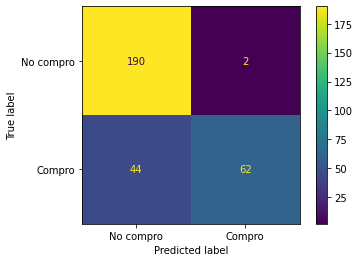

In [21]:
#Evaluamos
print(classification_report(y_test, y_test_pred, digits=3))
plot_confusion_matrix(best_gbm, X_test ,y_test, display_labels=['No compro','Compro'])

## Decision tree

In [22]:
params = {'criterion': ['gini','entropy'], 'max_depth': range(1,15,1), 'min_samples_leaf': range(1,10,1), 'min_samples_split': [2, 3, 4,5]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=0), params, cv=3, scoring='f1', n_jobs=-1)
grid_search_cv.fit(X_train, y_train)

grid_search_cv.best_estimator_

DecisionTreeClassifier(max_depth=3, random_state=0)

In [23]:
best_dt = grid_search_cv.best_estimator_
best_dt.fit(X_train, y_train)

y_train_pred = best_dt.predict(X_train)
y_test_pred = best_dt.predict(X_test)

              precision    recall  f1-score   support

         0.0      0.812     0.990     0.892       192
         1.0      0.969     0.585     0.729       106

    accuracy                          0.846       298
   macro avg      0.890     0.787     0.811       298
weighted avg      0.868     0.846     0.834       298



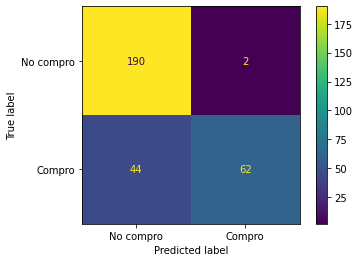

In [24]:
#Evaluamos
print(classification_report(y_test, y_test_pred, digits=3))
plot_confusion_matrix(best_dt, X_test ,y_test, display_labels=['No compro','Compro'])

## Random Forest

In [25]:
params = {'n_estimators': range(100,500,100), 'max_features': ['auto','sqrt', 'log2'], 'max_depth' : [4,5,6,7,8], 'criterion' :['gini', 'entropy']}
grid_search_cv = GridSearchCV(RandomForestClassifier(random_state=0), params, scoring='f1', n_jobs=-1)
grid_search_cv.fit(X_train, y_train)

grid_search_cv.best_estimator_

RandomForestClassifier(max_depth=7, max_features='log2', n_estimators=400,
                       random_state=0)

In [26]:
best_rf = grid_search_cv.best_estimator_ #RandomForestClassifier(random_state=0, criterion= "gini", max_depth=7, max_features="log2", n_estimators=400)
best_rf.fit(X_train, y_train)

y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

              precision    recall  f1-score   support

         0.0      0.812     0.990     0.892       192
         1.0      0.969     0.585     0.729       106

    accuracy                          0.846       298
   macro avg      0.890     0.787     0.811       298
weighted avg      0.868     0.846     0.834       298



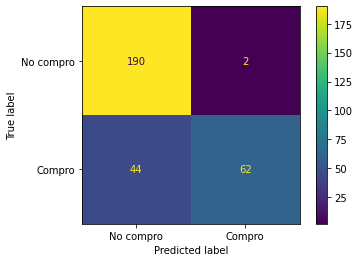

In [27]:
#Evaluamos
print(classification_report(y_test, y_test_pred, digits=3))
plot_confusion_matrix(best_rf, X_test ,y_test, display_labels=['No compro','Compro'])

## KNN

In [28]:
params = {'n_neighbors':range(2,8), 'p':range(1,4), 'weights': ['distance','uniform'], 'metric':["euclidean","manhattan" ]}
grid_search_cv = GridSearchCV(KNeighborsClassifier(), params, cv=3, scoring='f1', n_jobs=-1)
grid_search_cv.fit(X_train, y_train)

grid_search_cv.best_estimator_

KNeighborsClassifier(metric='manhattan', n_neighbors=7, p=1, weights='distance')

In [29]:
best_knn = grid_search_cv.best_estimator_
best_knn.fit(X_train, y_train)

y_train_pred = best_knn.predict(X_train)
y_test_pred = best_knn.predict(X_test)

              precision    recall  f1-score   support

         0.0      0.771     0.859     0.813       192
         1.0      0.679     0.538     0.600       106

    accuracy                          0.745       298
   macro avg      0.725     0.699     0.706       298
weighted avg      0.738     0.745     0.737       298



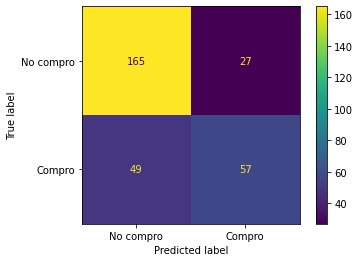

In [30]:
#Evaluamos
print(classification_report(y_test, y_test_pred, digits=3))
plot_confusion_matrix(best_knn, X_test ,y_test, display_labels=['No compro','Compro'])

# Selección de modelo

Probamos los distintos modelos en Kaggle (sobre todo considerando que los modelos basados en arboles de decisión nos dieron el mismo puntaje f1 en el conjunto de test). El modelo que nos dio la mejor performance fue el de random forest classifier. 

Ahora reentrenaremos el modelo ganador con todos los datos ya etiquetados (train+test) y luego lo haremos predecir con los datos que se utilizarán para la competencia.



In [31]:
best_rf.fit(X, y)

y_test_pred = best_rf.predict(df_test_scaled.drop(columns=['Customer', "GraduateOrNot_No", "Employment Type_Private Sector/Self Employed","FrequentFlyer_No","EverTravelledAbroad_No" ]))

In [32]:
client_prediction = pd.DataFrame(y_test_pred, columns=['TravelInsurance'], dtype='bool')

df_export = pd.concat([df_test[['Customer']], client_prediction], axis=1)

In [33]:
df_export.to_csv('kaggle_diplodatos_rf.csv', index=False)